    This notebook was made to compare surface current within different stations in the Fraser River

In [1]:
from __future__ import division

from cStringIO import StringIO
from salishsea_tools import (
    nc_tools,
    viz_tools,
    stormtools,
    tidetools,
)
from glob import glob
from salishsea_tools.nowcast import figures
from matplotlib import pylab
from dateutil import tz
from matplotlib.backends import backend_agg as backend
from scipy import interpolate as interp
from matplotlib import animation
import scipy.io as sio
import datetime
import os
import arrow
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import netCDF4 as nc
import numpy as np
import pandas as pd
import requests

In [2]:
%matplotlib inline

In [3]:
sites = {
    'Sandheads': {
        'lat': 49.10,
        'lon': -123.30,
        'i' : 426,
        'j' : 293
   
    },
    'Deas Island':{
        'lat' : 48.12,
        'lon' : -123.07,
        'i' : 414,
        'j' : 328
    },    
    'New Westminster': {
        'lat': 49.21,
        'lon': -122.89,
        'i': 418,
        'j': 365
        },

    'Mission': {
        'lat': 48.59,
        'lon': -123.2,
        'i':  515,
        'j':369
    },


        }
# Font format
title_font = {
    'fontname': 'Bitstream Vera Sans', 'size': '16', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'Bitstream Vera Sans', 'size': '14'}

In [4]:
def results_dataset(period, grid, results_dir):
    """Return the results dataset for period (e.g. 1h or 1d)
    and grid (e.g. grid_T, grid_U) from results_dir.
    """
    filename_pattern = 'SalishSea_{period}_*_{grid}.nc'
    filepaths = glob(os.path.join(results_dir, filename_pattern.format(period=period, grid=grid)))
    return nc.Dataset(filepaths[0])

In [5]:
run_date = datetime.datetime(2015,6,15)
# new results dataset location
results_home_now = '/ocean/jieliu/research/meopar/river-treatment/'
results_dir_now = os.path.join(results_home_now, run_date.strftime('%d%b%y').lower())

In [6]:
grid_T = results_dataset('1h', 'grid_T', results_dir_now)
grid_U_now = results_dataset('1h', 'grid_U', results_dir_now)
grid_V_now = results_dataset('1h', 'grid_V', results_dir_now)

In [7]:
## currents for straight river channel
u_now = grid_U_now.variables['vozocrtx']
v_now = grid_V_now.variables['vomecrty']
hours = grid_U_now.variables['time_counter']
hour = hours[:]/3600

In [8]:
def compare_surfacecurrent_at_stns(grid_T, PST,m, u_now,v_now):
    '''This function was made to compare surface currents at different 
        Fraser River stations during a day'''
    ##some constant parameters
    time_shift = datetime.timedelta(hours=-8)
    t_orig, t_final, t = figures.get_model_time_variables(grid_T)
    start_date = t_orig.strftime('%d-%b-%Y')
    end_date = t_final.strftime('%d-%b-%Y')
    timezone = PST * '[PST]' + abs((PST - 1)) * '[UTC]'
    fig, axs = plt.subplots(2, 1, figsize=(15, 8))
    names = ['Sandheads', 'Deas Island', 'New Westminster', 'Mission']
    ax = axs[0]
    for name, M in zip(names,m):
        u_now_st = u_now[:, 0, sites[name]['i'], sites[name]['j']]
        ax.plot(hour, u_now_st, linewidth=2, label=name)
        ax.grid('on')
        ax.set_xlim([0, 24])

        ticks = range(24)
        ax.set_xticks(ticks, minor = False)
        ax.set_xticklabels(ticks)
        ax.set_ylim([-2,1])
        ax.set_title(
            'Hourly Surface Current at Fraser River stations: {t_orig:%d-%b-%Y}'
            .format( t_orig=t_orig),
            **title_font)
        ax.set_ylabel('zonal surface current u (m/s)', **axis_font)
        plt.setp(ax.get_xticklabels(), fontsize=12)
        plt.setp(ax.get_yticklabels(), fontsize=12)
    legend = ax.legend(
                bbox_to_anchor=(0.,0.5), loc=2, borderaxespad=0.,
                prop={'size': 12}, title=r'Legend')
    legend.get_title().set_fontsize('12')

    ax = axs[1]
    for name, M in zip(names,m):
        v_now_st = v_now[:, 0, sites[name]['i'], sites[name]['j']]
        ax.plot(hour, v_now_st, linewidth=2, label=name)
        ax.grid('on')
        ax.set_xlim([0, 24])
        ticks = range(24)
        ax.set_xticks(ticks, minor = False)
        ax.set_xticklabels(ticks)
        ax.set_ylim([-2,1])
        ax.set_title(
            'Hourly Surface Current at Fraser River stations: {t_orig:%d-%b-%Y}'
                .format( t_orig=t_orig),
                **title_font)
        ax.set_ylabel('meridional surface current v (m/s)', **axis_font)
        ax.set_xlabel('Time hr {}'.format(timezone), **axis_font)
        plt.setp(ax.get_xticklabels(), fontsize=12)
        plt.setp(ax.get_yticklabels(), fontsize=12)
    legend = ax.legend(
                bbox_to_anchor=(0.,0.5), loc=2, borderaxespad=0.,
                prop={'size': 12}, title=r'Legend')
    legend.get_title().set_fontsize('12')
    return fig   

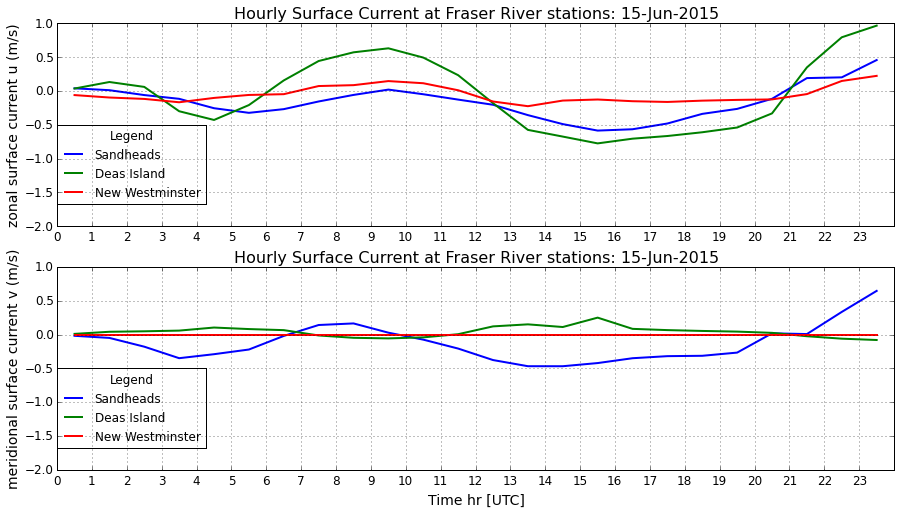

In [9]:
fig = compare_surfacecurrent_at_stns(grid_T, 0, range(3), u_now, v_now)

In [11]:
## surface currents for north extended river channel
results_home= '/ocean/jieliu/research/meopar/river-treatment/north-extd/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())
grid_T_nor = results_dataset('1h', 'grid_T', results_dir)
grid_U_nor = results_dataset('1h', 'grid_U', results_dir)
grid_V_nor = results_dataset('1h', 'grid_V', results_dir)
u_nor = grid_U_nor.variables['vozocrtx']
v_nor = grid_V_nor.variables['vomecrty']

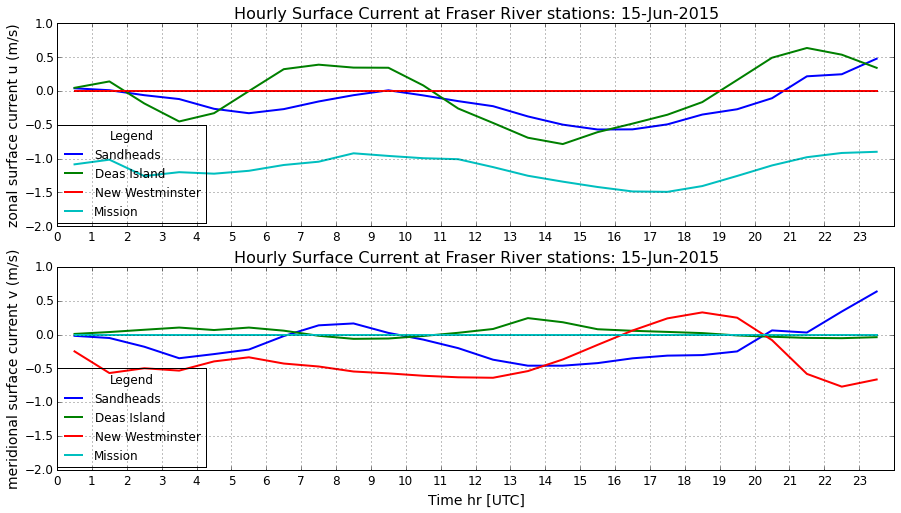

In [12]:
figg = compare_surfacecurrent_at_stns(grid_T_nor, 0, range(4), u_nor, v_nor)